# Imports, Downloads & Cuda availability | MUST-RUN

In [ ]:
!pip install transformers

import torch
from tqdm import tqdm
import pandas as pd
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import get_linear_schedule_with_warmup
import random
import numpy as np
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve, auc
from transformers import BertForSequenceClassification, AdamW, BertConfig

import string
import nltk
import unicodedata
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')
import re
from itertools import cycle

import matplotlib.pyplot as plt
% matplotlib inline

import time
import datetime


if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('Using gpu')
else:
    device = torch.device("cpu")
    print('Using cpu')

     |████████████████████████████████| 3.8 MB 9.7 MB/s 
     |████████████████████████████████| 6.5 MB 35.6 MB/s 
     |████████████████████████████████| 596 kB 31.1 MB/s 
     |████████████████████████████████| 67 kB 1.8 MB/s 
     |████████████████████████████████| 895 kB 38.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
Using gpu


# Preprocessing & Print functions

In [ ]:
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if (i not in string.punctuation)])
    return punctuationfree

def add_prefix_NOT_(text):
  neg_array = ["n’t","n't", "not", "no", "never"]
  final_txt = ""
  flg = 0;
  for i in text.split():
    if flg == 1:
      final_txt = final_txt + " NOT_" + i
    else:
      final_txt = final_txt + " " + i
    if i.endswith(tuple(neg_array)):
      flg = 1
    else:
      flg = 0
  return final_txt

def strip_accents(s):
   return ''.join(c for c in unicodedata.normalize('NFD', s)
                  if unicodedata.category(c) != 'Mn')
   
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
def stem(text):
    return [stemmer.stem(word) for word in text]
def lem(text):
  return [lemmatizer.lemmatize(word) for word in text]
def split(text):
  return re.split(' ',text)
def stringify(text):
  return ' '.join(text)

def print_function(iters,losses,losses_Val,f1_train_scores,
               f1_train_scores_Val,precision_train_scores,precision_train_scores_Val,recall_train_scores,recall_train_scores_Val,f1_train_0,f1_train_1,f1_train_2,f1_train_0_Val,f1_train_1_Val,f1_train_2_Val):

  plt.title("F1 Score for each class")
  plt.plot(iters, f1_train_0, label="Class 0 f1 score")
  plt.plot(iters, f1_train_0_Val, label="Class 0 f1 score _Val")
  plt.plot(iters, f1_train_1, label="Class 1 f1 score")
  plt.plot(iters, f1_train_1_Val, label="Class 1 f1 score _Val")
  plt.plot(iters, f1_train_2, label="Class 2 f1 score")
  plt.plot(iters, f1_train_2_Val, label="Class 2 f1 score _Val")
  plt.xlabel("Epoch")
  plt.ylabel("F1 Score")
  plt.legend(loc='best')
  plt.show()
  
  plt.title("Learning Curve ")
  plt.plot(iters, losses, label="Train")
  plt.plot(iters, losses_Val, label="Val")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("F1 Score")
  plt.plot(iters, f1_train_scores, label="f1 score")
  plt.plot(iters, f1_train_scores_Val, label="f1 score _Val")
  plt.xlabel("Epoch")
  plt.ylabel("F1 Score")
  plt.legend(loc='best')
  plt.show()

  plt.title("Precision Score")
  plt.plot(iters, precision_train_scores, label="precision score")
  plt.plot(iters, precision_train_scores_Val, label="precision score _Val")
  plt.xlabel("Epoch")
  plt.ylabel("precision Score")
  plt.legend(loc='best')
  plt.show()

  plt.title("Recall Score")
  plt.plot(iters, recall_train_scores, label="recall score")
  plt.plot(iters, recall_train_scores_Val, label="recall score _Val")
  plt.xlabel("Epoch")
  plt.ylabel("Recall Score")
  plt.legend(loc='best')
  plt.show()

# Read train & validation files

In [ ]:
data = pd.read_csv("/content/vaccine_train_set.csv")
data_val = pd.read_csv("/content/vaccine_validation_set.csv")

# Fine tuning BERT w/ lr 1e-5

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


Epoch: 0
Training:


100%|██████████| 999/999 [20:03<00:00,  1.21s/it]


 F1 score for class 0 : 0.8686286407766991  class 1 : 0.1687279151943463  class 2 : 0.8645172656800564
 Total f1 score: 0.6444174287636851
 Total precision : 0.6533750212569651
 Total recall : 0.6774274274274275
 Total Average loss : 0.7352205185560851

Validation: 


100%|██████████| 143/143 [01:03<00:00,  2.24it/s]


 F1 score for class 0 : 0.890625  class 1 : 0.5904761904761905  class 2 : 0.8775137111517368
 Total f1 score: 0.7391301644427387
 Total precision : 0.7673830057374635
 Total recall : 0.7449300699300699
 Total average loss : 0.6049348061734979

Epoch: 1
Training:


100%|██████████| 999/999 [20:01<00:00,  1.20s/it]


 F1 score for class 0 : 0.914489484025908  class 1 : 0.6651641983258211  class 2 : 0.8916595012897677
 Total f1 score: 0.7764797813741688
 Total precision : 0.8027966305744089
 Total recall : 0.7824074074074074
 Total Average loss : 0.5368177073600294

Validation: 


100%|██████████| 143/143 [01:03<00:00,  2.23it/s]


 F1 score for class 0 : 0.8753959873284055  class 1 : 0.751054852320675  class 2 : 0.8809234507897935
 Total f1 score: 0.7616900601311124
 Total precision : 0.7956840229021171
 Total recall : 0.7596153846153846
 Total average loss : 0.5886925662626753

Epoch: 2
Training:


100%|██████████| 999/999 [20:02<00:00,  1.20s/it]


 F1 score for class 0 : 0.9408506710217994  class 1 : 0.8144123534458108  class 2 : 0.9275314086030452
 Total f1 score: 0.8511099001095195
 Total precision : 0.8733346136123927
 Total recall : 0.8526026026026026
 Total Average loss : 0.39621626216549055

Validation: 


100%|██████████| 143/143 [01:03<00:00,  2.24it/s]


 F1 score for class 0 : 0.8706256627783668  class 1 : 0.7186147186147186  class 2 : 0.8903614457831326
 Total f1 score: 0.755492870748025
 Total precision : 0.7868768105437682
 Total recall : 0.756993006993007
 Total average loss : 0.6889131809291723


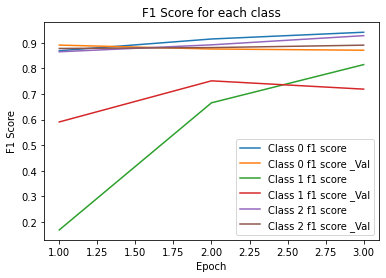

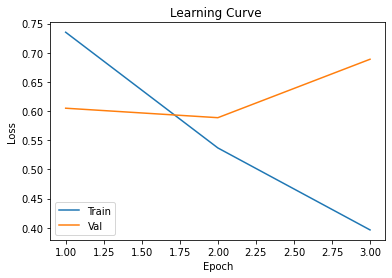

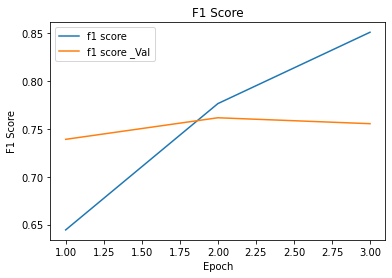

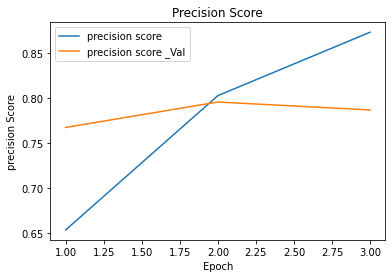

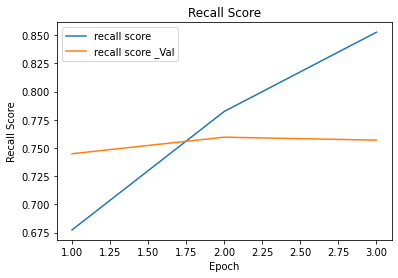

In [ ]:
torch.cuda.empty_cache()
#Save train and validation data in variables 
train_sentences = data.tweet.values
correct_labels = data.label.values

val_sentences = data_val.tweet.values
correct_labels_val = data_val.label.values

#String tokenizer for BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

#Tokenize each tweet and transform into torch.tensor

#Train tokenization
ids_list = []
mask_list = []

for sentance in train_sentences:
    #Using tokenizer.encode_plus for tokenization, add special tokens, create token ids, create attention mask and padding until max length.
    tok_dictionary = tokenizer.encode_plus(sentance,add_special_tokens = True,max_length = 220,padding='max_length',return_attention_mask = True,return_tensors = 'pt',truncation=True)
    
    ids_list.append(tok_dictionary['input_ids'])
    
    mask_list.append(tok_dictionary['attention_mask'])

#Lists into torch.tensors
ids_list = torch.cat(ids_list, dim=0)
mask_list = torch.cat(mask_list, dim=0)
correct_labels = torch.tensor(correct_labels)

#Validation tokenization
ids_list_val = []
mask_list_val = []

for sent in val_sentences:
    tok_dictionary_val = tokenizer.encode_plus(sent,add_special_tokens = True,max_length = 220,padding='max_length',return_attention_mask = True,return_tensors = 'pt',truncation=True)
    
    ids_list_val.append(tok_dictionary_val['input_ids'])
    
    mask_list_val.append(tok_dictionary_val['attention_mask'])

ids_list_val = torch.cat(ids_list_val, dim=0)
mask_list_val = torch.cat(mask_list_val, dim=0)
correct_labels_val = torch.tensor(correct_labels_val)


#Create TensorDatasets to group our values.
train_dataset = TensorDataset(ids_list, mask_list, correct_labels)

val_dataset = TensorDataset(ids_list_val, mask_list_val, correct_labels_val)

#Batch size & dataloaders for training loop
batch_size = 16

train_dataloader = DataLoader(train_dataset,sampler = SequentialSampler(train_dataset),batch_size = batch_size)

validation_dataloader = DataLoader(val_dataset,sampler = SequentialSampler(val_dataset),batch_size = batch_size)


#Using bert-base-uncased BertForSequenceClassification for our model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels = 3,output_attentions = False,output_hidden_states = False)

#Run model in Cuda
model.cuda()

#Using Adam optimizer with learning rate 1e-5.
optimizer = AdamW(model.parameters(),lr = 1e-5)

#For Bert fine tuning we will need to train the pre-trained model for our dataset
epochs = 3


#Lists for graphs
losses,f1_train_scores,precision_train_scores,recall_train_scores = [], [], [], []
losses_Val,f1_train_scores_Val,precision_train_scores_Val,recall_train_scores_Val = [], [], [], []

f1_train_0,f1_train_1,f1_train_2 = [],[],[]
f1_train_0_Val,f1_train_1_Val,f1_train_2_Val = [],[],[]

n_epoch=0
iters = []

for curr_epoch in range(0, epochs):
    batch_lo,batch_f1,batch_pre,batch_rec = [],[],[],[]
    val_batch_los,val_batch_f1,val_batch_pre,val_batch_rec = [],[],[],[]

    label_list, logits_list = [],[]
    p_label, p_logits = [],[]
    n_label, n_logits = [],[]
    a_label, a_logits = [],[]
    

    print(f"\nEpoch: {curr_epoch}")
    print("Training:")
    model.train()

    for batch in tqdm(train_dataloader):

        #Get batche's data
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        #Clearning gradients
        model.zero_grad()

        #Run a forward pass
        result = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels,return_dict=True)

        #Get loss and logits data
        loss = result.loss
        logits = result.logits

        #Backward pass
        loss.backward()

        #Clipping that helps for exploding gradients problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        #Move data to cpu
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        #Save data into lists for calculations.
        batch_lo.append(loss.item())
        batch_f1.append( f1_score(label_ids.flatten(),np.argmax(logits,axis=1).flatten(), average='weighted') )
        batch_pre.append( precision_score(label_ids.flatten(),np.argmax(logits,axis=1).flatten(), average='weighted',zero_division=0) )
        batch_rec.append( recall_score(label_ids.flatten(),np.argmax(logits,axis=1).flatten(), average='weighted',zero_division=0) )

        label_list.append(label_ids.flatten())
        logits_list.append(np.argmax(logits,axis=1).flatten())

        lbl_l = label_ids.flatten()
        lgl_l = np.argmax(logits,axis=1).flatten()

        for i,label in enumerate(lbl_l):
          if label == 0:
            p_label.append(label)
            p_logits.append(lgl_l[i])
          elif label == 1:
            a_label.append(label)
            a_logits.append(lgl_l[i])       
          elif label == 2:
            n_label.append(label)
            n_logits.append(lgl_l[i])  



    losses.append(sum(batch_lo)/len(train_dataloader))

    f1_train_scores.append(sum(batch_f1)/len(train_dataloader))

    precision_train_scores.append(sum(batch_pre)/len(train_dataloader))

    recall_train_scores.append(sum(batch_rec)/len(train_dataloader))

    f1_train_0.append(f1_score(p_label,p_logits, average='weighted'))
    f1_train_1.append(f1_score(a_label,a_logits, average='weighted'))
    f1_train_2.append(f1_score(n_label,n_logits, average='weighted'))

    print(f" F1 score for class 0 : {f1_score(p_label,p_logits, average='weighted')}  class 1 : {f1_score(a_label,a_logits, average='weighted')}  class 2 : {f1_score(n_label,n_logits, average='weighted')}")

    print(f" Total f1 score: {sum(batch_f1)/len(train_dataloader)}")
    print(f" Total precision : {sum(batch_pre)/len(train_dataloader)}")
    print(f" Total recall : {sum(batch_rec)/len(train_dataloader)}")
    print(f" Total Average loss : {sum(batch_lo)/len(train_dataloader)}")

    print("\nValidation: ")

    model.eval()

    label_list, logits_list = [],[]
    p_label, p_logits = [],[]
    n_label, n_logits = [],[]
    a_label, a_logits = [],[]

    for batch in tqdm(validation_dataloader):
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        

        with torch.no_grad():        
            result = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask,labels=b_labels,return_dict=True)

        loss = result.loss
        logits = result.logits
            

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        val_batch_los.append(loss.item())
        val_batch_f1.append( f1_score(label_ids.flatten(),np.argmax(logits,axis=1).flatten(), average='weighted') )
        val_batch_pre.append( precision_score(label_ids.flatten(),np.argmax(logits,axis=1).flatten(), average='weighted',zero_division=0) )
        val_batch_rec.append( recall_score(label_ids.flatten(),np.argmax(logits,axis=1).flatten(), average='weighted',zero_division=0) )

        label_list.append(label_ids.flatten())
        logits_list.append(np.argmax(logits,axis=1).flatten())

        lbl_l = label_ids.flatten()
        lgl_l = np.argmax(logits,axis=1).flatten()

        for i,label in enumerate(lbl_l):
          if label == 0:
            p_label.append(label)
            p_logits.append(lgl_l[i])
          elif label == 1:
            a_label.append(label)
            a_logits.append(lgl_l[i])       
          elif label == 2:
            n_label.append(label)
            n_logits.append(lgl_l[i])  

    n_epoch+=1
    iters.append(n_epoch)

    losses_Val.append(sum(val_batch_los)/len(validation_dataloader))

    f1_train_scores_Val.append(sum(val_batch_f1)/len(validation_dataloader))

    precision_train_scores_Val.append(sum(val_batch_pre)/len(validation_dataloader))

    recall_train_scores_Val.append(sum(val_batch_rec)/len(validation_dataloader))

    f1_train_0_Val.append(f1_score(p_label,p_logits, average='weighted'))
    f1_train_1_Val.append(f1_score(a_label,a_logits, average='weighted'))
    f1_train_2_Val.append(f1_score(n_label,n_logits, average='weighted'))

    for i,label in enumerate(label_list):
      for j,lbl in enumerate(label):
        if lbl == 0:
          p_label.append(lbl)
          p_logits.append(logits_list[i][j])
        elif lbl == 1:
          a_label.append(lbl)
          a_logits.append(logits_list[i][j])       
        elif lbl == 2:
          n_label.append(lbl)
          n_logits.append(logits_list[i][j])  

    print(f" F1 score for class 0 : {f1_score(p_label,p_logits, average='weighted')}  class 1 : {f1_score(a_label,a_logits, average='weighted')}  class 2 : {f1_score(n_label,n_logits, average='weighted')}")
  
    print(f" Total f1 score: {sum(val_batch_f1)/len(validation_dataloader)}")
    print(f" Total precision : {sum(val_batch_pre)/len(validation_dataloader)}")
    print(f" Total recall : {sum(val_batch_rec)/len(validation_dataloader)}")
    print(f" Total average loss : {sum(val_batch_los)/len(validation_dataloader)}")

print_function(iters,losses,losses_Val,f1_train_scores,
               f1_train_scores_Val,precision_train_scores,precision_train_scores_Val,recall_train_scores,recall_train_scores_Val,f1_train_0,f1_train_1,f1_train_2,f1_train_0_Val,f1_train_1_Val,f1_train_2_Val)

# Fine tuning BERT w/ lr 2e-5

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


Epoch: 0
Training:


100%|██████████| 999/999 [20:04<00:00,  1.21s/it]


 F1 score for class 0 : 0.8770609049160581  class 1 : 0.4541387024608501  class 2 : 0.8741374792558302
 Total f1 score: 0.6994629175726775
 Total precision : 0.7246233232344351
 Total recall : 0.7159034034034034
 Total Average loss : 0.6679382312062146

Validation: 


100%|██████████| 143/143 [01:04<00:00,  2.23it/s]


 F1 score for class 0 : 0.8492706645056727  class 1 : 0.8088531187122737  class 2 : 0.8976660682226213
 Total f1 score: 0.7686132530962787
 Total precision : 0.8114509606555058
 Total recall : 0.7615384615384616
 Total average loss : 0.5784212698886445

Epoch: 1
Training:


100%|██████████| 999/999 [20:01<00:00,  1.20s/it]


 F1 score for class 0 : 0.9259019226614819  class 1 : 0.7798705120659212  class 2 : 0.916988741388002
 Total f1 score: 0.824235838605582
 Total precision : 0.8497645539312212
 Total recall : 0.8268268268268268
 Total Average loss : 0.4481921199489165

Validation: 


100%|██████████| 143/143 [01:03<00:00,  2.24it/s]


 F1 score for class 0 : 0.895800933125972  class 1 : 0.8207171314741035  class 2 : 0.8415094339622642
 Total f1 score: 0.7649227744485597
 Total precision : 0.798247759185259
 Total recall : 0.7624125874125874
 Total average loss : 0.6416105906238089

Epoch: 2
Training:


100%|██████████| 999/999 [19:59<00:00,  1.20s/it]


 F1 score for class 0 : 0.9579432723208048  class 1 : 0.8926282051282052  class 2 : 0.9560217056774923
 Total f1 score: 0.9028925336650501
 Total precision : 0.9194904363307144
 Total recall : 0.9030280280280281
 Total Average loss : 0.28677322259275345

Validation: 


100%|██████████| 143/143 [01:03<00:00,  2.24it/s]


 F1 score for class 0 : 0.8813025210084033  class 1 : 0.758909853249476  class 2 : 0.876829268292683
 Total f1 score: 0.7615444495856143
 Total precision : 0.7899709507664051
 Total recall : 0.7626748251748252
 Total average loss : 0.8798538965361935


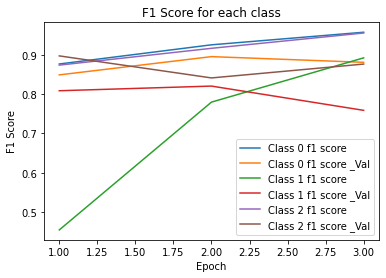

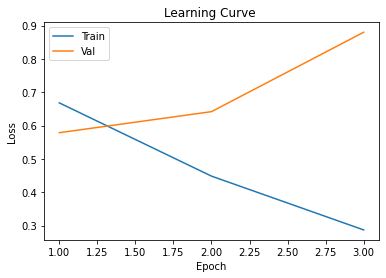

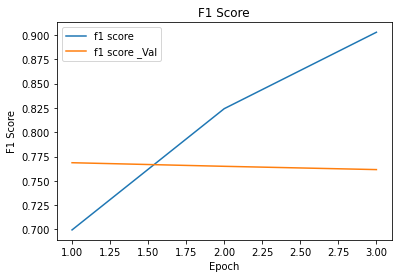

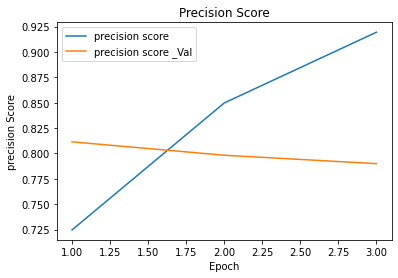

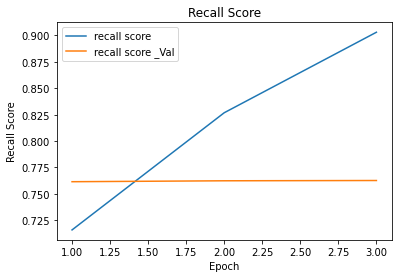

In [ ]:
torch.cuda.empty_cache()
#Save train and validation data in variables 
train_sentences = data.tweet.values
correct_labels = data.label.values

val_sentences = data_val.tweet.values
correct_labels_val = data_val.label.values

#String tokenizer for BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

#Tokenize each tweet and transform into torch.tensor

#Train tokenization
ids_list = []
mask_list = []

for sentance in train_sentences:
    #Using tokenizer.encode_plus for tokenization, add special tokens, create token ids, create attention mask and padding until max length.
    tok_dictionary = tokenizer.encode_plus(sentance,add_special_tokens = True,max_length = 220,padding='max_length',return_attention_mask = True,return_tensors = 'pt',truncation=True)
    
    ids_list.append(tok_dictionary['input_ids'])
    
    mask_list.append(tok_dictionary['attention_mask'])

#Lists into torch.tensors
ids_list = torch.cat(ids_list, dim=0)
mask_list = torch.cat(mask_list, dim=0)
correct_labels = torch.tensor(correct_labels)

#Validation tokenization
ids_list_val = []
mask_list_val = []

for sent in val_sentences:
    tok_dictionary_val = tokenizer.encode_plus(sent,add_special_tokens = True,max_length = 220,padding='max_length',return_attention_mask = True,return_tensors = 'pt',truncation=True)
    
    ids_list_val.append(tok_dictionary_val['input_ids'])
    
    mask_list_val.append(tok_dictionary_val['attention_mask'])

ids_list_val = torch.cat(ids_list_val, dim=0)
mask_list_val = torch.cat(mask_list_val, dim=0)
correct_labels_val = torch.tensor(correct_labels_val)


#Create TensorDatasets to group our values.
train_dataset = TensorDataset(ids_list, mask_list, correct_labels)

val_dataset = TensorDataset(ids_list_val, mask_list_val, correct_labels_val)

#Batch size & dataloaders for training loop
batch_size = 16

train_dataloader = DataLoader(train_dataset,sampler = SequentialSampler(train_dataset),batch_size = batch_size)

validation_dataloader = DataLoader(val_dataset,sampler = SequentialSampler(val_dataset),batch_size = batch_size)


#Using bert-base-uncased BertForSequenceClassification for our model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels = 3,output_attentions = False,output_hidden_states = False)

#Run model in Cuda
model.cuda()

#Using Adam optimizer with learning rate 2e-5.
optimizer = AdamW(model.parameters(),lr = 2e-5)

#For Bert fine tuning we will need to train the pre-trained model for our dataset
epochs = 3


#Lists for graphs
losses,f1_train_scores,precision_train_scores,recall_train_scores = [], [], [], []
losses_Val,f1_train_scores_Val,precision_train_scores_Val,recall_train_scores_Val = [], [], [], []

f1_train_0,f1_train_1,f1_train_2 = [],[],[]
f1_train_0_Val,f1_train_1_Val,f1_train_2_Val = [],[],[]

n_epoch=0
iters = []

for curr_epoch in range(0, epochs):
    batch_lo,batch_f1,batch_pre,batch_rec = [],[],[],[]
    val_batch_los,val_batch_f1,val_batch_pre,val_batch_rec = [],[],[],[]

    label_list, logits_list = [],[]
    p_label, p_logits = [],[]
    n_label, n_logits = [],[]
    a_label, a_logits = [],[]
    

    print(f"\nEpoch: {curr_epoch}")
    print("Training:")
    model.train()

    for batch in tqdm(train_dataloader):

        #Get batche's data
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        #Clearning gradients
        model.zero_grad()

        #Run a forward pass
        result = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels,return_dict=True)

        #Get loss and logits data
        loss = result.loss
        logits = result.logits

        #Backward pass
        loss.backward()

        #Clipping that helps for exploding gradients problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        #Move data to cpu
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        #Save data into lists for calculations.
        batch_lo.append(loss.item())
        batch_f1.append( f1_score(label_ids.flatten(),np.argmax(logits,axis=1).flatten(), average='weighted') )
        batch_pre.append( precision_score(label_ids.flatten(),np.argmax(logits,axis=1).flatten(), average='weighted',zero_division=0) )
        batch_rec.append( recall_score(label_ids.flatten(),np.argmax(logits,axis=1).flatten(), average='weighted',zero_division=0) )

        label_list.append(label_ids.flatten())
        logits_list.append(np.argmax(logits,axis=1).flatten())

        lbl_l = label_ids.flatten()
        lgl_l = np.argmax(logits,axis=1).flatten()

        for i,label in enumerate(lbl_l):
          if label == 0:
            p_label.append(label)
            p_logits.append(lgl_l[i])
          elif label == 1:
            a_label.append(label)
            a_logits.append(lgl_l[i])       
          elif label == 2:
            n_label.append(label)
            n_logits.append(lgl_l[i])  



    losses.append(sum(batch_lo)/len(train_dataloader))

    f1_train_scores.append(sum(batch_f1)/len(train_dataloader))

    precision_train_scores.append(sum(batch_pre)/len(train_dataloader))

    recall_train_scores.append(sum(batch_rec)/len(train_dataloader))

    f1_train_0.append(f1_score(p_label,p_logits, average='weighted'))
    f1_train_1.append(f1_score(a_label,a_logits, average='weighted'))
    f1_train_2.append(f1_score(n_label,n_logits, average='weighted'))

    print(f" F1 score for class 0 : {f1_score(p_label,p_logits, average='weighted')}  class 1 : {f1_score(a_label,a_logits, average='weighted')}  class 2 : {f1_score(n_label,n_logits, average='weighted')}")

    print(f" Total f1 score: {sum(batch_f1)/len(train_dataloader)}")
    print(f" Total precision : {sum(batch_pre)/len(train_dataloader)}")
    print(f" Total recall : {sum(batch_rec)/len(train_dataloader)}")
    print(f" Total Average loss : {sum(batch_lo)/len(train_dataloader)}")

    print("\nValidation: ")

    model.eval()

    label_list, logits_list = [],[]
    p_label, p_logits = [],[]
    n_label, n_logits = [],[]
    a_label, a_logits = [],[]

    for batch in tqdm(validation_dataloader):
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        

        with torch.no_grad():        
            result = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask,labels=b_labels,return_dict=True)

        loss = result.loss
        logits = result.logits
            

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        val_batch_los.append(loss.item())
        val_batch_f1.append( f1_score(label_ids.flatten(),np.argmax(logits,axis=1).flatten(), average='weighted') )
        val_batch_pre.append( precision_score(label_ids.flatten(),np.argmax(logits,axis=1).flatten(), average='weighted',zero_division=0) )
        val_batch_rec.append( recall_score(label_ids.flatten(),np.argmax(logits,axis=1).flatten(), average='weighted',zero_division=0) )

        label_list.append(label_ids.flatten())
        logits_list.append(np.argmax(logits,axis=1).flatten())

        lbl_l = label_ids.flatten()
        lgl_l = np.argmax(logits,axis=1).flatten()

        for i,label in enumerate(lbl_l):
          if label == 0:
            p_label.append(label)
            p_logits.append(lgl_l[i])
          elif label == 1:
            a_label.append(label)
            a_logits.append(lgl_l[i])       
          elif label == 2:
            n_label.append(label)
            n_logits.append(lgl_l[i])  

    n_epoch+=1
    iters.append(n_epoch)

    losses_Val.append(sum(val_batch_los)/len(validation_dataloader))

    f1_train_scores_Val.append(sum(val_batch_f1)/len(validation_dataloader))

    precision_train_scores_Val.append(sum(val_batch_pre)/len(validation_dataloader))

    recall_train_scores_Val.append(sum(val_batch_rec)/len(validation_dataloader))

    f1_train_0_Val.append(f1_score(p_label,p_logits, average='weighted'))
    f1_train_1_Val.append(f1_score(a_label,a_logits, average='weighted'))
    f1_train_2_Val.append(f1_score(n_label,n_logits, average='weighted'))

    for i,label in enumerate(label_list):
      for j,lbl in enumerate(label):
        if lbl == 0:
          p_label.append(lbl)
          p_logits.append(logits_list[i][j])
        elif lbl == 1:
          a_label.append(lbl)
          a_logits.append(logits_list[i][j])       
        elif lbl == 2:
          n_label.append(lbl)
          n_logits.append(logits_list[i][j])  

    print(f" F1 score for class 0 : {f1_score(p_label,p_logits, average='weighted')}  class 1 : {f1_score(a_label,a_logits, average='weighted')}  class 2 : {f1_score(n_label,n_logits, average='weighted')}")
  
    print(f" Total f1 score: {sum(val_batch_f1)/len(validation_dataloader)}")
    print(f" Total precision : {sum(val_batch_pre)/len(validation_dataloader)}")
    print(f" Total recall : {sum(val_batch_rec)/len(validation_dataloader)}")
    print(f" Total average loss : {sum(val_batch_los)/len(validation_dataloader)}")

print_function(iters,losses,losses_Val,f1_train_scores,
               f1_train_scores_Val,precision_train_scores,precision_train_scores_Val,recall_train_scores,recall_train_scores_Val,f1_train_0,f1_train_1,f1_train_2,f1_train_0_Val,f1_train_1_Val,f1_train_2_Val)


# Fine tuning BERT w/ preprocessing

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


Epoch: 0
Training:


100%|██████████| 999/999 [19:56<00:00,  1.20s/it]


 F1 score for class 0 : 0.8544658628369557  class 1 : 0.3829953198127925  class 2 : 0.8729561948063304
 Total f1 score: 0.671681310192798
 Total precision : 0.6982635297739461
 Total recall : 0.6913788788788788
 Total Average loss : 0.7038972598385882

Validation: 


100%|██████████| 143/143 [01:03<00:00,  2.24it/s]


 F1 score for class 0 : 0.8765822784810127  class 1 : 0.8527131782945736  class 2 : 0.8123791102514507
 Total f1 score: 0.7472253301466002
 Total precision : 0.7951485067962338
 Total recall : 0.7373251748251748
 Total average loss : 0.6068240918896415

Epoch: 1
Training:


100%|██████████| 999/999 [19:55<00:00,  1.20s/it]


 F1 score for class 0 : 0.9162246603211509  class 1 : 0.7538322813345356  class 2 : 0.9109496451503887
 Total f1 score: 0.8078771774255549
 Total precision : 0.836528720209277
 Total recall : 0.8105605605605606
 Total Average loss : 0.48556760312976305

Validation: 


100%|██████████| 143/143 [01:03<00:00,  2.24it/s]


 F1 score for class 0 : 0.871822033898305  class 1 : 0.8323471400394478  class 2 : 0.8304761904761905
 Total f1 score: 0.7498359494355221
 Total precision : 0.7912599710895167
 Total recall : 0.7401223776223776
 Total average loss : 0.6632632964870313

Epoch: 2
Training:


100%|██████████| 999/999 [19:49<00:00,  1.19s/it]


 F1 score for class 0 : 0.9503166783954962  class 1 : 0.880669546436285  class 2 : 0.9497270431027459
 Total f1 score: 0.8886012675736531
 Total precision : 0.9076245369648153
 Total recall : 0.8895145145145145
 Total Average loss : 0.3223256645267373

Validation: 


100%|██████████| 143/143 [01:03<00:00,  2.24it/s]


 F1 score for class 0 : 0.8801261829652998  class 1 : 0.6575963718820861  class 2 : 0.8910295003010236
 Total f1 score: 0.7489275231063723
 Total precision : 0.7744540439164561
 Total recall : 0.7549825174825175
 Total average loss : 0.8850437886101175


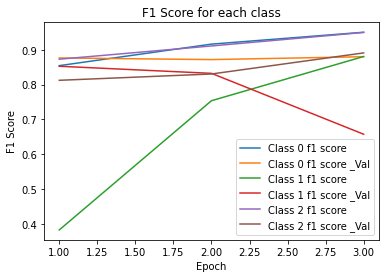

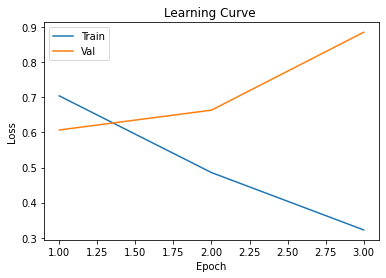

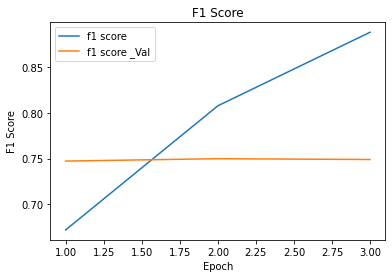

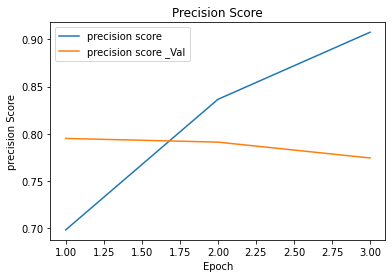

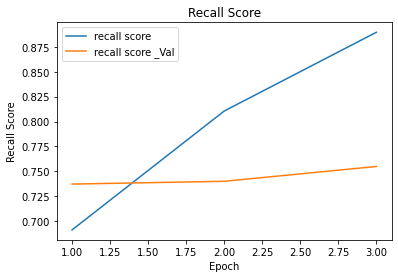

In [ ]:
torch.cuda.empty_cache()
#-------PREPROCESSING-------
#remove whitespaces
data['tweet'] = data['tweet'].str.strip()
data_val['tweet'] = data_val['tweet'].str.strip()
#Add prefix NOT_
data['tweet'] = data['tweet'].apply(lambda x:add_prefix_NOT_(x))
data_val['tweet'] = data_val['tweet'].apply(lambda x:add_prefix_NOT_(x))
# Remove links and url
data['tweet'] = data['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
data_val['tweet'] = data_val['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
#remove emojis and symbols
data['tweet']= data['tweet'].apply(lambda x:remove_emoji(x))
data_val['tweet']= data_val['tweet'].apply(lambda x:remove_emoji(x))
#remove punctuation
data['tweet']= data['tweet'].apply(lambda x:remove_punctuation(x))
data_val['tweet']= data_val['tweet'].apply(lambda x:remove_punctuation(x))
#lower case
data['tweet']= data['tweet'].apply(lambda x: x.lower())
data_val['tweet']= data_val['tweet'].apply(lambda x: x.lower())
#replace accents
data['tweet']= data['tweet'].apply(lambda x:strip_accents(x))
data_val['tweet']= data_val['tweet'].apply(lambda x:strip_accents(x))
#remove numbers
data['tweet'] = data['tweet'].str.replace('\d+', '',regex=True)
data_val['tweet'] = data_val['tweet'].str.replace('\d+', '',regex=True)

#Save train and validation data in variables 
train_sentences = data.tweet.values
correct_labels = data.label.values

val_sentences = data_val.tweet.values
correct_labels_val = data_val.label.values

#String tokenizer for BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

#Tokenize each tweet and transform into torch.tensor

#Train tokenization
ids_list = []
mask_list = []

for sentance in train_sentences:
    #Using tokenizer.encode_plus for tokenization, add special tokens, create token ids, create attention mask and padding until max length.
    tok_dictionary = tokenizer.encode_plus(sentance,add_special_tokens = True,max_length = 220,padding='max_length',return_attention_mask = True,return_tensors = 'pt',truncation=True)
    
    ids_list.append(tok_dictionary['input_ids'])
    
    mask_list.append(tok_dictionary['attention_mask'])

#Lists into torch.tensors
ids_list = torch.cat(ids_list, dim=0)
mask_list = torch.cat(mask_list, dim=0)
correct_labels = torch.tensor(correct_labels)

#Validation tokenization
ids_list_val = []
mask_list_val = []

for sent in val_sentences:
    tok_dictionary_val = tokenizer.encode_plus(sent,add_special_tokens = True,max_length = 220,padding='max_length',return_attention_mask = True,return_tensors = 'pt',truncation=True)
    
    ids_list_val.append(tok_dictionary_val['input_ids'])
    
    mask_list_val.append(tok_dictionary_val['attention_mask'])

ids_list_val = torch.cat(ids_list_val, dim=0)
mask_list_val = torch.cat(mask_list_val, dim=0)
correct_labels_val = torch.tensor(correct_labels_val)


#Create TensorDatasets to group our values.
train_dataset = TensorDataset(ids_list, mask_list, correct_labels)

val_dataset = TensorDataset(ids_list_val, mask_list_val, correct_labels_val)

#Batch size & dataloaders for training loop
batch_size = 16

train_dataloader = DataLoader(train_dataset,sampler = SequentialSampler(train_dataset),batch_size = batch_size)

validation_dataloader = DataLoader(val_dataset,sampler = SequentialSampler(val_dataset),batch_size = batch_size)


#Using bert-base-uncased BertForSequenceClassification for our model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels = 3,output_attentions = False,output_hidden_states = False)

#Run model in Cuda
model.cuda()

#Using Adam optimizer with learning rate 2e-5.
optimizer = AdamW(model.parameters(),lr = 2e-5)

#For Bert fine tuning we will need to train the pre-trained model for our dataset
epochs = 3


#Lists for graphs
losses,f1_train_scores,precision_train_scores,recall_train_scores = [], [], [], []
losses_Val,f1_train_scores_Val,precision_train_scores_Val,recall_train_scores_Val = [], [], [], []

f1_train_0,f1_train_1,f1_train_2 = [],[],[]
f1_train_0_Val,f1_train_1_Val,f1_train_2_Val = [],[],[]

n_epoch=0
iters = []

for curr_epoch in range(0, epochs):
    batch_lo,batch_f1,batch_pre,batch_rec = [],[],[],[]
    val_batch_los,val_batch_f1,val_batch_pre,val_batch_rec = [],[],[],[]

    label_list, logits_list = [],[]
    p_label, p_logits = [],[]
    n_label, n_logits = [],[]
    a_label, a_logits = [],[]
    

    print(f"\nEpoch: {curr_epoch}")
    print("Training:")
    model.train()

    for batch in tqdm(train_dataloader):

        #Get batche's data
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        #Clearning gradients
        model.zero_grad()

        #Run a forward pass
        result = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels,return_dict=True)

        #Get loss and logits data
        loss = result.loss
        logits = result.logits

        #Backward pass
        loss.backward()

        #Clipping that helps for exploding gradients problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        #Move data to cpu
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        #Save data into lists for calculations.
        batch_lo.append(loss.item())
        batch_f1.append( f1_score(label_ids.flatten(),np.argmax(logits,axis=1).flatten(), average='weighted') )
        batch_pre.append( precision_score(label_ids.flatten(),np.argmax(logits,axis=1).flatten(), average='weighted',zero_division=0) )
        batch_rec.append( recall_score(label_ids.flatten(),np.argmax(logits,axis=1).flatten(), average='weighted',zero_division=0) )

        label_list.append(label_ids.flatten())
        logits_list.append(np.argmax(logits,axis=1).flatten())

        lbl_l = label_ids.flatten()
        lgl_l = np.argmax(logits,axis=1).flatten()

        for i,label in enumerate(lbl_l):
          if label == 0:
            p_label.append(label)
            p_logits.append(lgl_l[i])
          elif label == 1:
            a_label.append(label)
            a_logits.append(lgl_l[i])       
          elif label == 2:
            n_label.append(label)
            n_logits.append(lgl_l[i])  



    losses.append(sum(batch_lo)/len(train_dataloader))

    f1_train_scores.append(sum(batch_f1)/len(train_dataloader))

    precision_train_scores.append(sum(batch_pre)/len(train_dataloader))

    recall_train_scores.append(sum(batch_rec)/len(train_dataloader))

    f1_train_0.append(f1_score(p_label,p_logits, average='weighted'))
    f1_train_1.append(f1_score(a_label,a_logits, average='weighted'))
    f1_train_2.append(f1_score(n_label,n_logits, average='weighted'))

    print(f" F1 score for class 0 : {f1_score(p_label,p_logits, average='weighted')}  class 1 : {f1_score(a_label,a_logits, average='weighted')}  class 2 : {f1_score(n_label,n_logits, average='weighted')}")

    print(f" Total f1 score: {sum(batch_f1)/len(train_dataloader)}")
    print(f" Total precision : {sum(batch_pre)/len(train_dataloader)}")
    print(f" Total recall : {sum(batch_rec)/len(train_dataloader)}")
    print(f" Total Average loss : {sum(batch_lo)/len(train_dataloader)}")

    print("\nValidation: ")

    model.eval()

    label_list, logits_list = [],[]
    p_label, p_logits = [],[]
    n_label, n_logits = [],[]
    a_label, a_logits = [],[]

    for batch in tqdm(validation_dataloader):
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        

        with torch.no_grad():        
            result = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask,labels=b_labels,return_dict=True)

        loss = result.loss
        logits = result.logits
            

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        val_batch_los.append(loss.item())
        val_batch_f1.append( f1_score(label_ids.flatten(),np.argmax(logits,axis=1).flatten(), average='weighted') )
        val_batch_pre.append( precision_score(label_ids.flatten(),np.argmax(logits,axis=1).flatten(), average='weighted',zero_division=0) )
        val_batch_rec.append( recall_score(label_ids.flatten(),np.argmax(logits,axis=1).flatten(), average='weighted',zero_division=0) )

        label_list.append(label_ids.flatten())
        logits_list.append(np.argmax(logits,axis=1).flatten())

        lbl_l = label_ids.flatten()
        lgl_l = np.argmax(logits,axis=1).flatten()

        for i,label in enumerate(lbl_l):
          if label == 0:
            p_label.append(label)
            p_logits.append(lgl_l[i])
          elif label == 1:
            a_label.append(label)
            a_logits.append(lgl_l[i])       
          elif label == 2:
            n_label.append(label)
            n_logits.append(lgl_l[i])  

    n_epoch+=1
    iters.append(n_epoch)

    losses_Val.append(sum(val_batch_los)/len(validation_dataloader))

    f1_train_scores_Val.append(sum(val_batch_f1)/len(validation_dataloader))

    precision_train_scores_Val.append(sum(val_batch_pre)/len(validation_dataloader))

    recall_train_scores_Val.append(sum(val_batch_rec)/len(validation_dataloader))

    f1_train_0_Val.append(f1_score(p_label,p_logits, average='weighted'))
    f1_train_1_Val.append(f1_score(a_label,a_logits, average='weighted'))
    f1_train_2_Val.append(f1_score(n_label,n_logits, average='weighted'))

    for i,label in enumerate(label_list):
      for j,lbl in enumerate(label):
        if lbl == 0:
          p_label.append(lbl)
          p_logits.append(logits_list[i][j])
        elif lbl == 1:
          a_label.append(lbl)
          a_logits.append(logits_list[i][j])       
        elif lbl == 2:
          n_label.append(lbl)
          n_logits.append(logits_list[i][j])  

    print(f" F1 score for class 0 : {f1_score(p_label,p_logits, average='weighted')}  class 1 : {f1_score(a_label,a_logits, average='weighted')}  class 2 : {f1_score(n_label,n_logits, average='weighted')}")
  
    print(f" Total f1 score: {sum(val_batch_f1)/len(validation_dataloader)}")
    print(f" Total precision : {sum(val_batch_pre)/len(validation_dataloader)}")
    print(f" Total recall : {sum(val_batch_rec)/len(validation_dataloader)}")
    print(f" Total average loss : {sum(val_batch_los)/len(validation_dataloader)}")

print_function(iters,losses,losses_Val,f1_train_scores,
               f1_train_scores_Val,precision_train_scores,precision_train_scores_Val,recall_train_scores,recall_train_scores_Val,f1_train_0,f1_train_1,f1_train_2,f1_train_0_Val,f1_train_1_Val,f1_train_2_Val) 
  


# Fine tuning BERT w/ scheduler

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


Epoch: 0
Training:


100%|██████████| 999/999 [20:01<00:00,  1.20s/it]


 F1 score for class 0 : 0.8642351328713928  class 1 : 0.3792025019546521  class 2 : 0.8639167988718491
 Total f1 score: 0.6717862779238868
 Total precision : 0.6952406071329676
 Total recall : 0.6923173173173173
 Total Average loss : 0.6949614170823131

Validation: 


100%|██████████| 143/143 [01:04<00:00,  2.23it/s]


 F1 score for class 0 : 0.8603531300160514  class 1 : 0.6989010989010989  class 2 : 0.9009546539379476
 Total f1 score: 0.7548244630612045
 Total precision : 0.7930970107980596
 Total recall : 0.7534965034965035
 Total average loss : 0.5975552035586817

Epoch: 1
Training:


100%|██████████| 999/999 [19:57<00:00,  1.20s/it]


 F1 score for class 0 : 0.9186602870813397  class 1 : 0.7527075812274369  class 2 : 0.9075345368251548
 Total f1 score: 0.8082775216359726
 Total precision : 0.8362489194086432
 Total recall : 0.809934934934935
 Total Average loss : 0.4767517265868378

Validation: 


100%|██████████| 143/143 [01:03<00:00,  2.26it/s]


 F1 score for class 0 : 0.8742071881606766  class 1 : 0.7268817204301075  class 2 : 0.896345116836429
 Total f1 score: 0.7643634642893123
 Total precision : 0.7981724120382335
 Total recall : 0.7648601398601399
 Total average loss : 0.6278805763467209

Epoch: 2
Training:


100%|██████████| 999/999 [19:46<00:00,  1.19s/it]


 F1 score for class 0 : 0.948614929160499  class 1 : 0.8628634119583105  class 2 : 0.9428360534733045
 Total f1 score: 0.8786465675481516
 Total precision : 0.8976043253821043
 Total recall : 0.8793168168168168
 Total Average loss : 0.3341259973476062

Validation: 


100%|██████████| 143/143 [01:03<00:00,  2.26it/s]


 F1 score for class 0 : 0.8894681960375391  class 1 : 0.6931567328918322  class 2 : 0.8849878934624698
 Total f1 score: 0.7625740544883226
 Total precision : 0.7946295691487999
 Total recall : 0.763548951048951
 Total average loss : 0.726060866449888


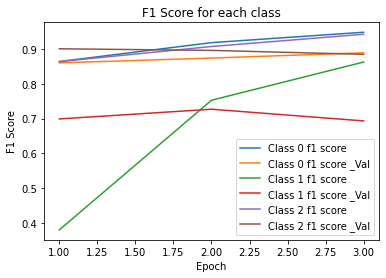

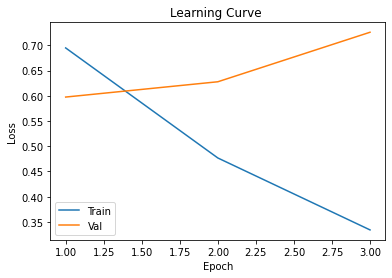

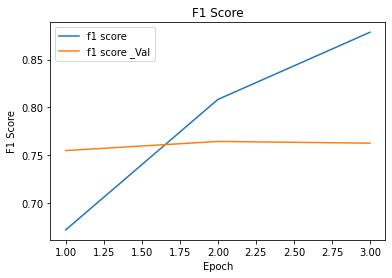

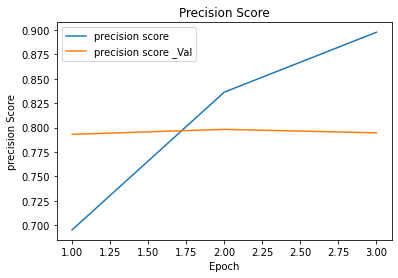

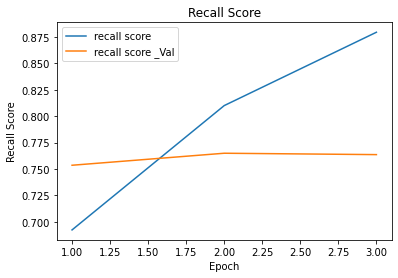

In [ ]:
torch.cuda.empty_cache()
#-------PREPROCESSING-------
#remove whitespaces
data['tweet'] = data['tweet'].str.strip()
data_val['tweet'] = data_val['tweet'].str.strip()
#Add prefix NOT_
data['tweet'] = data['tweet'].apply(lambda x:add_prefix_NOT_(x))
data_val['tweet'] = data_val['tweet'].apply(lambda x:add_prefix_NOT_(x))
# Remove links and url
data['tweet'] = data['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
data_val['tweet'] = data_val['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
#remove emojis and symbols
data['tweet']= data['tweet'].apply(lambda x:remove_emoji(x))
data_val['tweet']= data_val['tweet'].apply(lambda x:remove_emoji(x))
#remove punctuation
data['tweet']= data['tweet'].apply(lambda x:remove_punctuation(x))
data_val['tweet']= data_val['tweet'].apply(lambda x:remove_punctuation(x))
#lower case
data['tweet']= data['tweet'].apply(lambda x: x.lower())
data_val['tweet']= data_val['tweet'].apply(lambda x: x.lower())
#replace accents
data['tweet']= data['tweet'].apply(lambda x:strip_accents(x))
data_val['tweet']= data_val['tweet'].apply(lambda x:strip_accents(x))
#remove numbers
data['tweet'] = data['tweet'].str.replace('\d+', '',regex=True)
data_val['tweet'] = data_val['tweet'].str.replace('\d+', '',regex=True)

#Save train and validation data in variables 
train_sentences = data.tweet.values
correct_labels = data.label.values

val_sentences = data_val.tweet.values
correct_labels_val = data_val.label.values

#String tokenizer for BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

#Tokenize each tweet and transform into torch.tensor

#Train tokenization
ids_list = []
mask_list = []

for sentance in train_sentences:
    #Using tokenizer.encode_plus for tokenization, add special tokens, create token ids, create attention mask and padding until max length.
    tok_dictionary = tokenizer.encode_plus(sentance,add_special_tokens = True,max_length = 220,padding='max_length',return_attention_mask = True,return_tensors = 'pt',truncation=True)
    
    ids_list.append(tok_dictionary['input_ids'])
    
    mask_list.append(tok_dictionary['attention_mask'])

#Lists into torch.tensors
ids_list = torch.cat(ids_list, dim=0)
mask_list = torch.cat(mask_list, dim=0)
correct_labels = torch.tensor(correct_labels)

#Validation tokenization
ids_list_val = []
mask_list_val = []

for sent in val_sentences:
    tok_dictionary_val = tokenizer.encode_plus(sent,add_special_tokens = True,max_length = 220,padding='max_length',return_attention_mask = True,return_tensors = 'pt',truncation=True)
    
    ids_list_val.append(tok_dictionary_val['input_ids'])
    
    mask_list_val.append(tok_dictionary_val['attention_mask'])

ids_list_val = torch.cat(ids_list_val, dim=0)
mask_list_val = torch.cat(mask_list_val, dim=0)
correct_labels_val = torch.tensor(correct_labels_val)


#Create TensorDatasets to group our values.
train_dataset = TensorDataset(ids_list, mask_list, correct_labels)

val_dataset = TensorDataset(ids_list_val, mask_list_val, correct_labels_val)

#Batch size & dataloaders for training loop
batch_size = 16

train_dataloader = DataLoader(train_dataset,sampler = SequentialSampler(train_dataset),batch_size = batch_size)

validation_dataloader = DataLoader(val_dataset,sampler = SequentialSampler(val_dataset),batch_size = batch_size)


#Using bert-base-uncased BertForSequenceClassification for our model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels = 3,output_attentions = False,output_hidden_states = False)

#Run model in Cuda
model.cuda()

#Using Adam optimizer with learning rate 2e-5.
optimizer = AdamW(model.parameters(),lr = 2e-5)

#For Bert fine tuning we will need to train the pre-trained model for our dataset
epochs = 3

sch_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0,num_training_steps = sch_steps)

#Lists for graphs
losses,f1_train_scores,precision_train_scores,recall_train_scores = [], [], [], []
losses_Val,f1_train_scores_Val,precision_train_scores_Val,recall_train_scores_Val = [], [], [], []

f1_train_0,f1_train_1,f1_train_2 = [],[],[]
f1_train_0_Val,f1_train_1_Val,f1_train_2_Val = [],[],[]

n_epoch=0
iters = []

for curr_epoch in range(0, epochs):
    batch_lo,batch_f1,batch_pre,batch_rec = [],[],[],[]
    val_batch_los,val_batch_f1,val_batch_pre,val_batch_rec = [],[],[],[]

    label_list, logits_list = [],[]
    p_label, p_logits = [],[]
    n_label, n_logits = [],[]
    a_label, a_logits = [],[]
    

    print(f"\nEpoch: {curr_epoch}")
    print("Training:")
    model.train()

    for batch in tqdm(train_dataloader):

        #Get batche's data
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        #Clearning gradients
        model.zero_grad()

        #Run a forward pass
        result = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels,return_dict=True)

        #Get loss and logits data
        loss = result.loss
        logits = result.logits

        #Backward pass
        loss.backward()

        #Clipping that helps for exploding gradients problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        #Move data to cpu
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        #Save data into lists for calculations.
        batch_lo.append(loss.item())
        batch_f1.append( f1_score(label_ids.flatten(),np.argmax(logits,axis=1).flatten(), average='weighted') )
        batch_pre.append( precision_score(label_ids.flatten(),np.argmax(logits,axis=1).flatten(), average='weighted',zero_division=0) )
        batch_rec.append( recall_score(label_ids.flatten(),np.argmax(logits,axis=1).flatten(), average='weighted',zero_division=0) )

        label_list.append(label_ids.flatten())
        logits_list.append(np.argmax(logits,axis=1).flatten())

        lbl_l = label_ids.flatten()
        lgl_l = np.argmax(logits,axis=1).flatten()

        scheduler.step()

        for i,label in enumerate(lbl_l):
          if label == 0:
            p_label.append(label)
            p_logits.append(lgl_l[i])
          elif label == 1:
            a_label.append(label)
            a_logits.append(lgl_l[i])       
          elif label == 2:
            n_label.append(label)
            n_logits.append(lgl_l[i])  



    losses.append(sum(batch_lo)/len(train_dataloader))

    f1_train_scores.append(sum(batch_f1)/len(train_dataloader))

    precision_train_scores.append(sum(batch_pre)/len(train_dataloader))

    recall_train_scores.append(sum(batch_rec)/len(train_dataloader))

    f1_train_0.append(f1_score(p_label,p_logits, average='weighted'))
    f1_train_1.append(f1_score(a_label,a_logits, average='weighted'))
    f1_train_2.append(f1_score(n_label,n_logits, average='weighted'))

    print(f" F1 score for class 0 : {f1_score(p_label,p_logits, average='weighted')}  class 1 : {f1_score(a_label,a_logits, average='weighted')}  class 2 : {f1_score(n_label,n_logits, average='weighted')}")

    print(f" Total f1 score: {sum(batch_f1)/len(train_dataloader)}")
    print(f" Total precision : {sum(batch_pre)/len(train_dataloader)}")
    print(f" Total recall : {sum(batch_rec)/len(train_dataloader)}")
    print(f" Total Average loss : {sum(batch_lo)/len(train_dataloader)}")

    print("\nValidation: ")

    model.eval()

    label_list, logits_list = [],[]
    p_label, p_logits = [],[]
    n_label, n_logits = [],[]
    a_label, a_logits = [],[]

    for batch in tqdm(validation_dataloader):
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        

        with torch.no_grad():        
            result = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask,labels=b_labels,return_dict=True)

        loss = result.loss
        logits = result.logits
            

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        val_batch_los.append(loss.item())
        val_batch_f1.append( f1_score(label_ids.flatten(),np.argmax(logits,axis=1).flatten(), average='weighted') )
        val_batch_pre.append( precision_score(label_ids.flatten(),np.argmax(logits,axis=1).flatten(), average='weighted',zero_division=0) )
        val_batch_rec.append( recall_score(label_ids.flatten(),np.argmax(logits,axis=1).flatten(), average='weighted',zero_division=0) )

        label_list.append(label_ids.flatten())
        logits_list.append(np.argmax(logits,axis=1).flatten())

        lbl_l = label_ids.flatten()
        lgl_l = np.argmax(logits,axis=1).flatten()

        
        for i,label in enumerate(lbl_l):
          if label == 0:
            p_label.append(label)
            p_logits.append(lgl_l[i])
          elif label == 1:
            a_label.append(label)
            a_logits.append(lgl_l[i])       
          elif label == 2:
            n_label.append(label)
            n_logits.append(lgl_l[i])  

    n_epoch+=1
    iters.append(n_epoch)

    losses_Val.append(sum(val_batch_los)/len(validation_dataloader))

    f1_train_scores_Val.append(sum(val_batch_f1)/len(validation_dataloader))

    precision_train_scores_Val.append(sum(val_batch_pre)/len(validation_dataloader))

    recall_train_scores_Val.append(sum(val_batch_rec)/len(validation_dataloader))

    f1_train_0_Val.append(f1_score(p_label,p_logits, average='weighted'))
    f1_train_1_Val.append(f1_score(a_label,a_logits, average='weighted'))
    f1_train_2_Val.append(f1_score(n_label,n_logits, average='weighted'))

    for i,label in enumerate(label_list):
      for j,lbl in enumerate(label):
        if lbl == 0:
          p_label.append(lbl)
          p_logits.append(logits_list[i][j])
        elif lbl == 1:
          a_label.append(lbl)
          a_logits.append(logits_list[i][j])       
        elif lbl == 2:
          n_label.append(lbl)
          n_logits.append(logits_list[i][j])  

    print(f" F1 score for class 0 : {f1_score(p_label,p_logits, average='weighted')}  class 1 : {f1_score(a_label,a_logits, average='weighted')}  class 2 : {f1_score(n_label,n_logits, average='weighted')}")
  
    print(f" Total f1 score: {sum(val_batch_f1)/len(validation_dataloader)}")
    print(f" Total precision : {sum(val_batch_pre)/len(validation_dataloader)}")
    print(f" Total recall : {sum(val_batch_rec)/len(validation_dataloader)}")
    print(f" Total average loss : {sum(val_batch_los)/len(validation_dataloader)}")

print_function(iters,losses,losses_Val,f1_train_scores,
               f1_train_scores_Val,precision_train_scores,precision_train_scores_Val,recall_train_scores,recall_train_scores_Val,f1_train_0,f1_train_1,f1_train_2,f1_train_0_Val,f1_train_1_Val,f1_train_2_Val)


# Fine tuning BERT w/ optimizer params & clipping ~ Final

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


Epoch: 0
Training:


100%|██████████| 999/999 [18:56<00:00,  1.14s/it]


 F1 score for class 0 : 0.8670818775634209  class 1 : 0.3880248833592535  class 2 : 0.8722659667541558
 Total f1 score: 0.6804942569239034
 Total precision : 0.7010343322843319
 Total recall : 0.7004504504504504
 Total Average loss : 0.6863486218201863

Validation: 


100%|██████████| 143/143 [00:59<00:00,  2.41it/s]


 F1 score for class 0 : 0.8572961373390559  class 1 : 0.6785714285714285  class 2 : 0.9081209247184352
 Total f1 score: 0.7513142585828931
 Total precision : 0.7887551672298176
 Total recall : 0.752534965034965
 Total average loss : 0.5881900253829423

Epoch: 1
Training:


100%|██████████| 999/999 [18:56<00:00,  1.14s/it]


 F1 score for class 0 : 0.9199131064446053  class 1 : 0.768270944741533  class 2 : 0.9075345368251548
 Total f1 score: 0.8111462567120666
 Total precision : 0.8393715459687704
 Total recall : 0.8134384384384384
 Total Average loss : 0.4737015601743509

Validation: 


100%|██████████| 143/143 [00:59<00:00,  2.40it/s]


 F1 score for class 0 : 0.870026525198939  class 1 : 0.6484018264840182  class 2 : 0.9139150943396227
 Total f1 score: 0.7550884713251094
 Total precision : 0.7863687485300247
 Total recall : 0.7612762237762237
 Total average loss : 0.6370453426575328

Epoch: 2
Training:


100%|██████████| 999/999 [18:56<00:00,  1.14s/it]


 F1 score for class 0 : 0.9500950235799254  class 1 : 0.8702997275204359  class 2 : 0.9427493438320209
 Total f1 score: 0.8816385010020971
 Total precision : 0.9005576528145984
 Total recall : 0.882007007007007
 Total Average loss : 0.328417415554459

Validation: 


100%|██████████| 143/143 [00:59<00:00,  2.40it/s]


 F1 score for class 0 : 0.8830624016780283  class 1 : 0.7017543859649124  class 2 : 0.880243161094225
 Total f1 score: 0.7548339815297995
 Total precision : 0.7801397187214492
 Total recall : 0.7567307692307693
 Total average loss : 0.7192978825081479


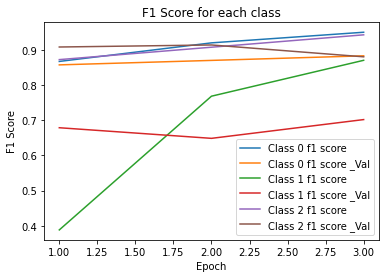

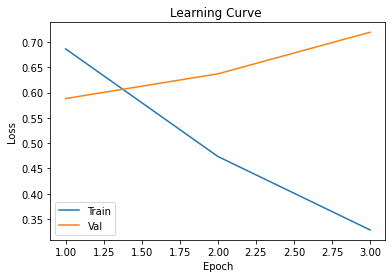

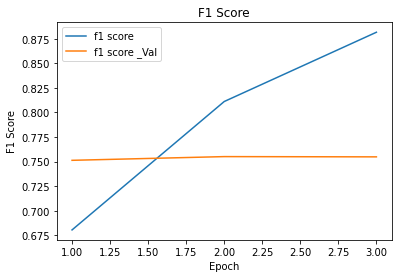

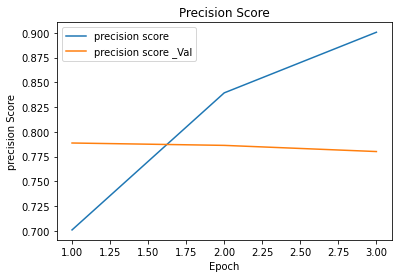

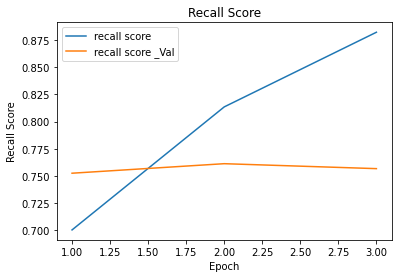

In [ ]:
torch.cuda.empty_cache()
#-------PREPROCESSING-------
#remove whitespaces
data['tweet'] = data['tweet'].str.strip()
data_val['tweet'] = data_val['tweet'].str.strip()
#Add prefix NOT_
data['tweet'] = data['tweet'].apply(lambda x:add_prefix_NOT_(x))
data_val['tweet'] = data_val['tweet'].apply(lambda x:add_prefix_NOT_(x))
# Remove links and url
data['tweet'] = data['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
data_val['tweet'] = data_val['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
#remove emojis and symbols
data['tweet']= data['tweet'].apply(lambda x:remove_emoji(x))
data_val['tweet']= data_val['tweet'].apply(lambda x:remove_emoji(x))
#remove punctuation
data['tweet']= data['tweet'].apply(lambda x:remove_punctuation(x))
data_val['tweet']= data_val['tweet'].apply(lambda x:remove_punctuation(x))
#lower case
data['tweet']= data['tweet'].apply(lambda x: x.lower())
data_val['tweet']= data_val['tweet'].apply(lambda x: x.lower())
#replace accents
data['tweet']= data['tweet'].apply(lambda x:strip_accents(x))
data_val['tweet']= data_val['tweet'].apply(lambda x:strip_accents(x))
#remove numbers
data['tweet'] = data['tweet'].str.replace('\d+', '',regex=True)
data_val['tweet'] = data_val['tweet'].str.replace('\d+', '',regex=True)

#Save train and validation data in variables 
train_sentences = data.tweet.values
correct_labels = data.label.values

val_sentences = data_val.tweet.values
correct_labels_val = data_val.label.values

#String tokenizer for BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

#Tokenize each tweet and transform into torch.tensor

#Train tokenization
ids_list = []
mask_list = []

for sentance in train_sentences:
    #Using tokenizer.encode_plus for tokenization, add special tokens, create token ids, create attention mask and padding until max length.
    tok_dictionary = tokenizer.encode_plus(sentance,add_special_tokens = True,max_length = 220,padding='max_length',return_attention_mask = True,return_tensors = 'pt',truncation=True)
    
    ids_list.append(tok_dictionary['input_ids'])
    
    mask_list.append(tok_dictionary['attention_mask'])

#Lists into torch.tensors
ids_list = torch.cat(ids_list, dim=0)
mask_list = torch.cat(mask_list, dim=0)
correct_labels = torch.tensor(correct_labels)

#Validation tokenization
ids_list_val = []
mask_list_val = []

for sent in val_sentences:
    tok_dictionary_val = tokenizer.encode_plus(sent,add_special_tokens = True,max_length = 220,padding='max_length',return_attention_mask = True,return_tensors = 'pt',truncation=True)
    
    ids_list_val.append(tok_dictionary_val['input_ids'])
    
    mask_list_val.append(tok_dictionary_val['attention_mask'])

ids_list_val = torch.cat(ids_list_val, dim=0)
mask_list_val = torch.cat(mask_list_val, dim=0)
correct_labels_val = torch.tensor(correct_labels_val)


#Create TensorDatasets to group our values.
train_dataset = TensorDataset(ids_list, mask_list, correct_labels)

val_dataset = TensorDataset(ids_list_val, mask_list_val, correct_labels_val)

#Batch size & dataloaders for training loop
batch_size = 16

train_dataloader = DataLoader(train_dataset,sampler = SequentialSampler(train_dataset),batch_size = batch_size)

validation_dataloader = DataLoader(val_dataset,sampler = SequentialSampler(val_dataset),batch_size = batch_size)


#Using bert-base-uncased BertForSequenceClassification for our model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels = 3,output_attentions = False,output_hidden_states = False)

#Run model in Cuda
model.cuda()

#Using Adam optimizer with learning rate 2e-5 and epsilon 5e-9 for numerical stability.
optimizer = AdamW(model.parameters(),lr = 2e-5,eps = 5e-9)

#For Bert fine tuning we will need to train the pre-trained model for our dataset
epochs = 3

sch_steps = len(train_dataloader) * epochs

#Creating scheduler with warmup
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0,num_training_steps = sch_steps)


#Lists for graphs
losses,f1_train_scores,precision_train_scores,recall_train_scores = [], [], [], []
losses_Val,f1_train_scores_Val,precision_train_scores_Val,recall_train_scores_Val = [], [], [], []

f1_train_0,f1_train_1,f1_train_2 = [],[],[]
f1_train_0_Val,f1_train_1_Val,f1_train_2_Val = [],[],[]

n_epoch=0
iters = []

for curr_epoch in range(0, epochs):
    batch_lo,batch_f1,batch_pre,batch_rec = [],[],[],[]
    val_batch_los,val_batch_f1,val_batch_pre,val_batch_rec = [],[],[],[]

    label_list, logits_list = [],[]
    p_label, p_logits = [],[]
    n_label, n_logits = [],[]
    a_label, a_logits = [],[]
    

    print(f"\nEpoch: {curr_epoch}")
    print("Training:")
    model.train()

    for batch in tqdm(train_dataloader):

        #Get batche's data
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        #Clearning gradients
        model.zero_grad()

        #Run a forward pass
        result = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels,return_dict=True)

        #Get loss and logits data
        loss = result.loss
        logits = result.logits

        #Backward pass
        loss.backward()

        #Clipping that helps for exploding gradients problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        #Move data to cpu
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        #Save data into lists for calculations.
        batch_lo.append(loss.item())
        batch_f1.append( f1_score(label_ids.flatten(),np.argmax(logits,axis=1).flatten(), average='weighted') )
        batch_pre.append( precision_score(label_ids.flatten(),np.argmax(logits,axis=1).flatten(), average='weighted',zero_division=0) )
        batch_rec.append( recall_score(label_ids.flatten(),np.argmax(logits,axis=1).flatten(), average='weighted',zero_division=0) )

        label_list.append(label_ids.flatten())
        logits_list.append(np.argmax(logits,axis=1).flatten())

        lbl_l = label_ids.flatten()
        lgl_l = np.argmax(logits,axis=1).flatten()

        scheduler.step()

        for i,label in enumerate(lbl_l):
          if label == 0:
            p_label.append(label)
            p_logits.append(lgl_l[i])
          elif label == 1:
            a_label.append(label)
            a_logits.append(lgl_l[i])       
          elif label == 2:
            n_label.append(label)
            n_logits.append(lgl_l[i])  



    losses.append(sum(batch_lo)/len(train_dataloader))

    f1_train_scores.append(sum(batch_f1)/len(train_dataloader))

    precision_train_scores.append(sum(batch_pre)/len(train_dataloader))

    recall_train_scores.append(sum(batch_rec)/len(train_dataloader))

    f1_train_0.append(f1_score(p_label,p_logits, average='weighted'))
    f1_train_1.append(f1_score(a_label,a_logits, average='weighted'))
    f1_train_2.append(f1_score(n_label,n_logits, average='weighted'))

    print(f" F1 score for class 0 : {f1_score(p_label,p_logits, average='weighted')}  class 1 : {f1_score(a_label,a_logits, average='weighted')}  class 2 : {f1_score(n_label,n_logits, average='weighted')}")

    print(f" Total f1 score: {sum(batch_f1)/len(train_dataloader)}")
    print(f" Total precision : {sum(batch_pre)/len(train_dataloader)}")
    print(f" Total recall : {sum(batch_rec)/len(train_dataloader)}")
    print(f" Total Average loss : {sum(batch_lo)/len(train_dataloader)}")

    print("\nValidation: ")

    model.eval()

    label_list, logits_list = [],[]
    p_label, p_logits = [],[]
    n_label, n_logits = [],[]
    a_label, a_logits = [],[]

    for batch in tqdm(validation_dataloader):
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        

        with torch.no_grad():        
            result = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask,labels=b_labels,return_dict=True)

        loss = result.loss
        logits = result.logits
            

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        val_batch_los.append(loss.item())
        val_batch_f1.append( f1_score(label_ids.flatten(),np.argmax(logits,axis=1).flatten(), average='weighted') )
        val_batch_pre.append( precision_score(label_ids.flatten(),np.argmax(logits,axis=1).flatten(), average='weighted',zero_division=0) )
        val_batch_rec.append( recall_score(label_ids.flatten(),np.argmax(logits,axis=1).flatten(), average='weighted',zero_division=0) )

        label_list.append(label_ids.flatten())
        logits_list.append(np.argmax(logits,axis=1).flatten())

        lbl_l = label_ids.flatten()
        lgl_l = np.argmax(logits,axis=1).flatten()

        
        for i,label in enumerate(lbl_l):
          if label == 0:
            p_label.append(label)
            p_logits.append(lgl_l[i])
          elif label == 1:
            a_label.append(label)
            a_logits.append(lgl_l[i])       
          elif label == 2:
            n_label.append(label)
            n_logits.append(lgl_l[i])  

    n_epoch+=1
    iters.append(n_epoch)

    losses_Val.append(sum(val_batch_los)/len(validation_dataloader))

    f1_train_scores_Val.append(sum(val_batch_f1)/len(validation_dataloader))

    precision_train_scores_Val.append(sum(val_batch_pre)/len(validation_dataloader))

    recall_train_scores_Val.append(sum(val_batch_rec)/len(validation_dataloader))

    f1_train_0_Val.append(f1_score(p_label,p_logits, average='weighted'))
    f1_train_1_Val.append(f1_score(a_label,a_logits, average='weighted'))
    f1_train_2_Val.append(f1_score(n_label,n_logits, average='weighted'))

    for i,label in enumerate(label_list):
      for j,lbl in enumerate(label):
        if lbl == 0:
          p_label.append(lbl)
          p_logits.append(logits_list[i][j])
        elif lbl == 1:
          a_label.append(lbl)
          a_logits.append(logits_list[i][j])       
        elif lbl == 2:
          n_label.append(lbl)
          n_logits.append(logits_list[i][j])  

    print(f" F1 score for class 0 : {f1_score(p_label,p_logits, average='weighted')}  class 1 : {f1_score(a_label,a_logits, average='weighted')}  class 2 : {f1_score(n_label,n_logits, average='weighted')}")
  
    print(f" Total f1 score: {sum(val_batch_f1)/len(validation_dataloader)}")
    print(f" Total precision : {sum(val_batch_pre)/len(validation_dataloader)}")
    print(f" Total recall : {sum(val_batch_rec)/len(validation_dataloader)}")
    print(f" Total average loss : {sum(val_batch_los)/len(validation_dataloader)}")

print_function(iters,losses,losses_Val,f1_train_scores,
               f1_train_scores_Val,precision_train_scores,precision_train_scores_Val,recall_train_scores,recall_train_scores_Val,f1_train_0,f1_train_1,f1_train_2,f1_train_0_Val,f1_train_1_Val,f1_train_2_Val)
  
